In [1]:
import h5py
import numpy as np
import pickle
import scipy
# print(scipy.__version__, scipy.__file__)
# from scipy.stats import bootstrap
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

import dynesty
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
from utils import *

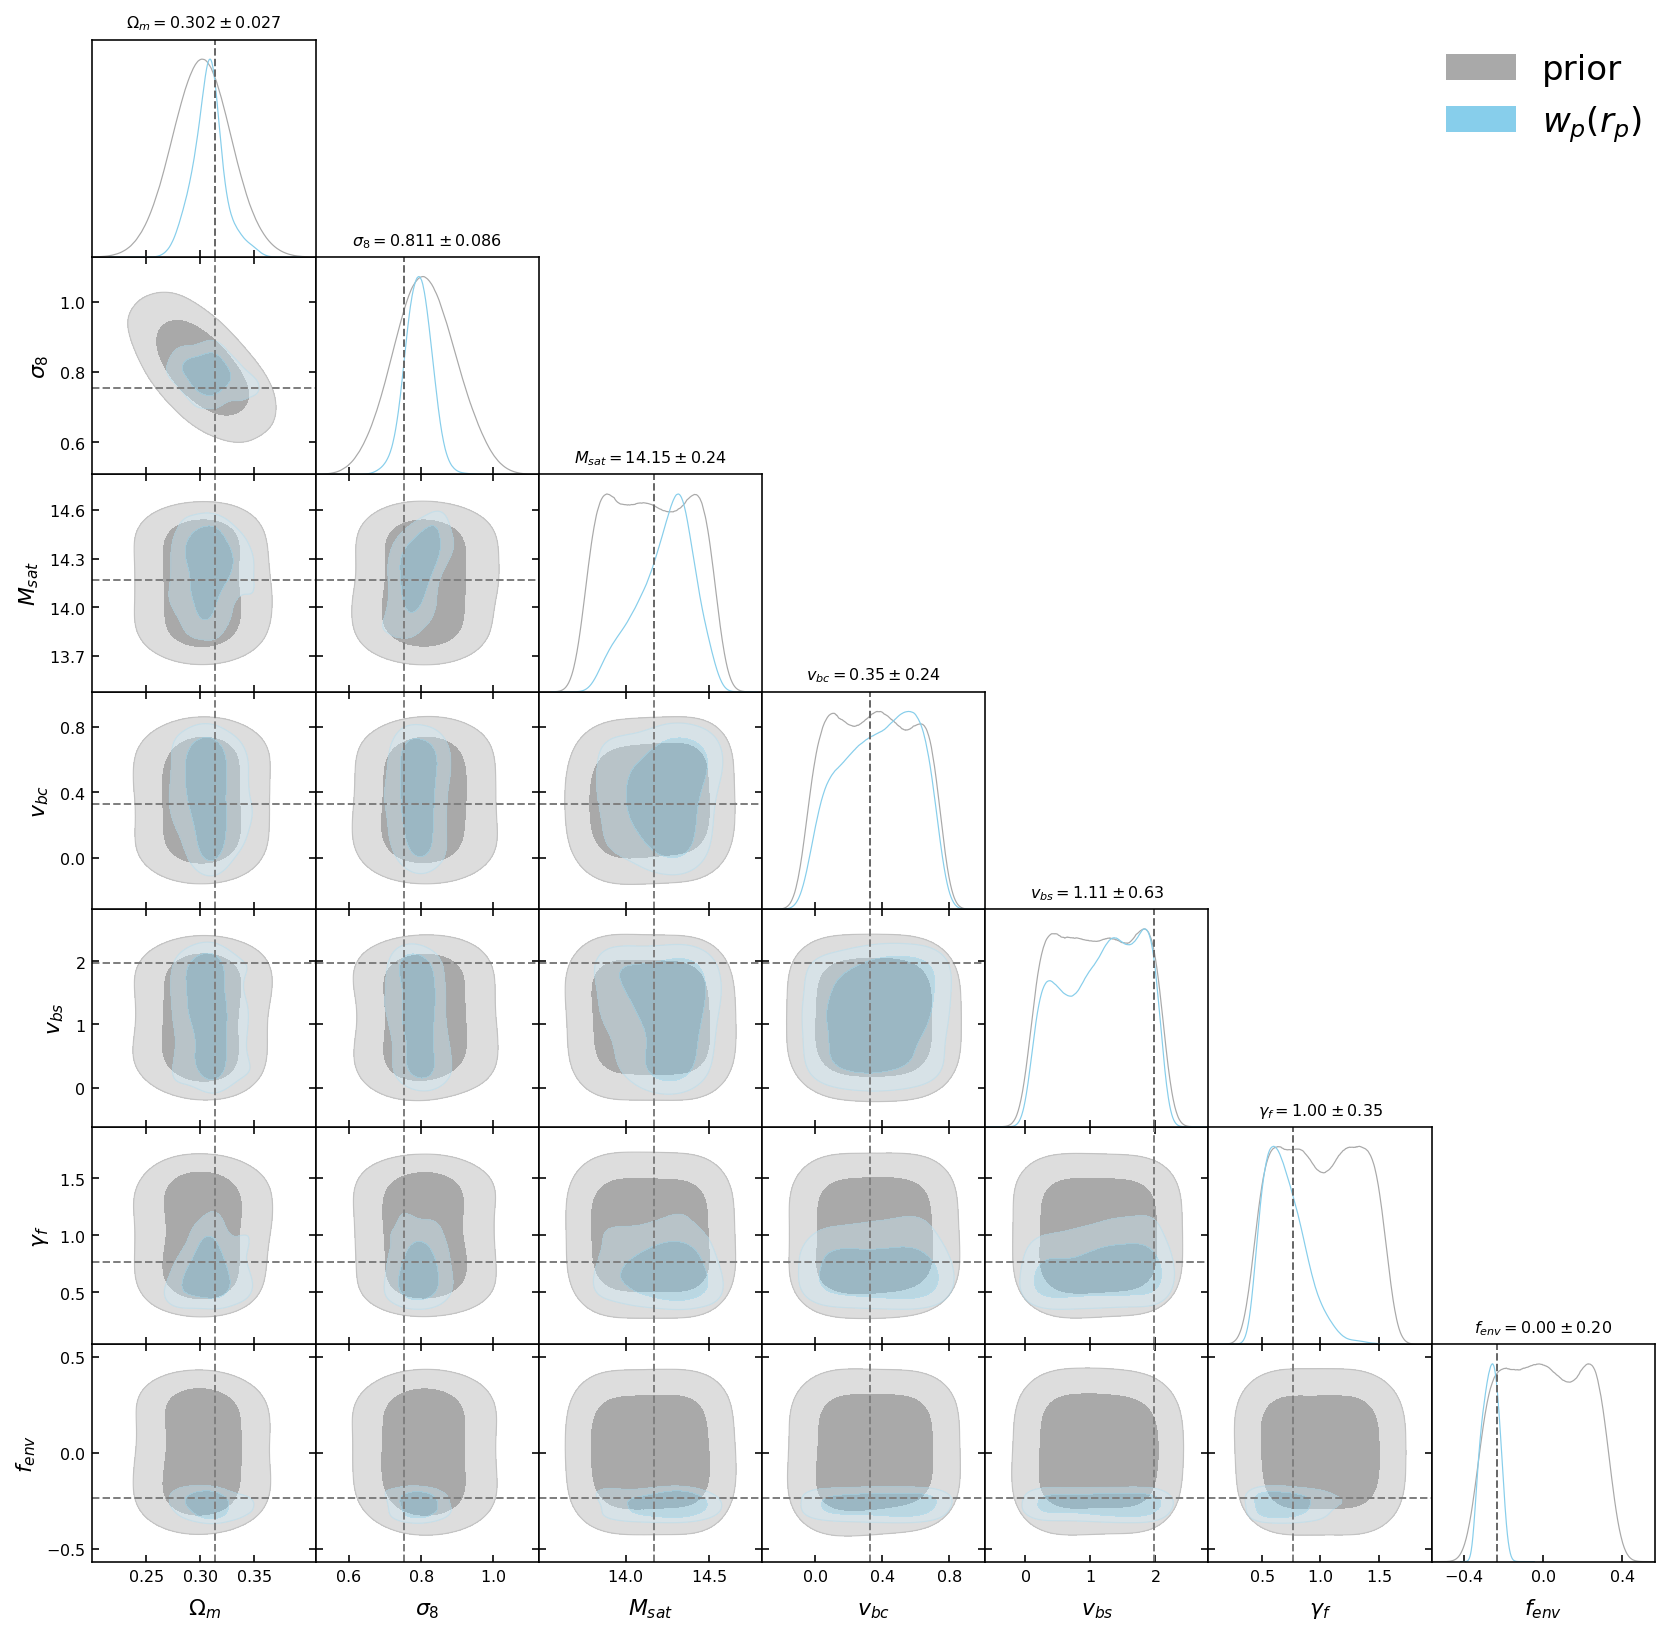

In [39]:
chaintags = [
             'prior',
             #'prior_seed0',
             'wp_c1h12_all',
            ]
legend_labels = [
                 'prior',
                 #'prior seed0',
                 make_label('wp'),
                ]
colors = ['darkgrey',
          #'lightgrey',
          'skyblue',
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=key_param_names)

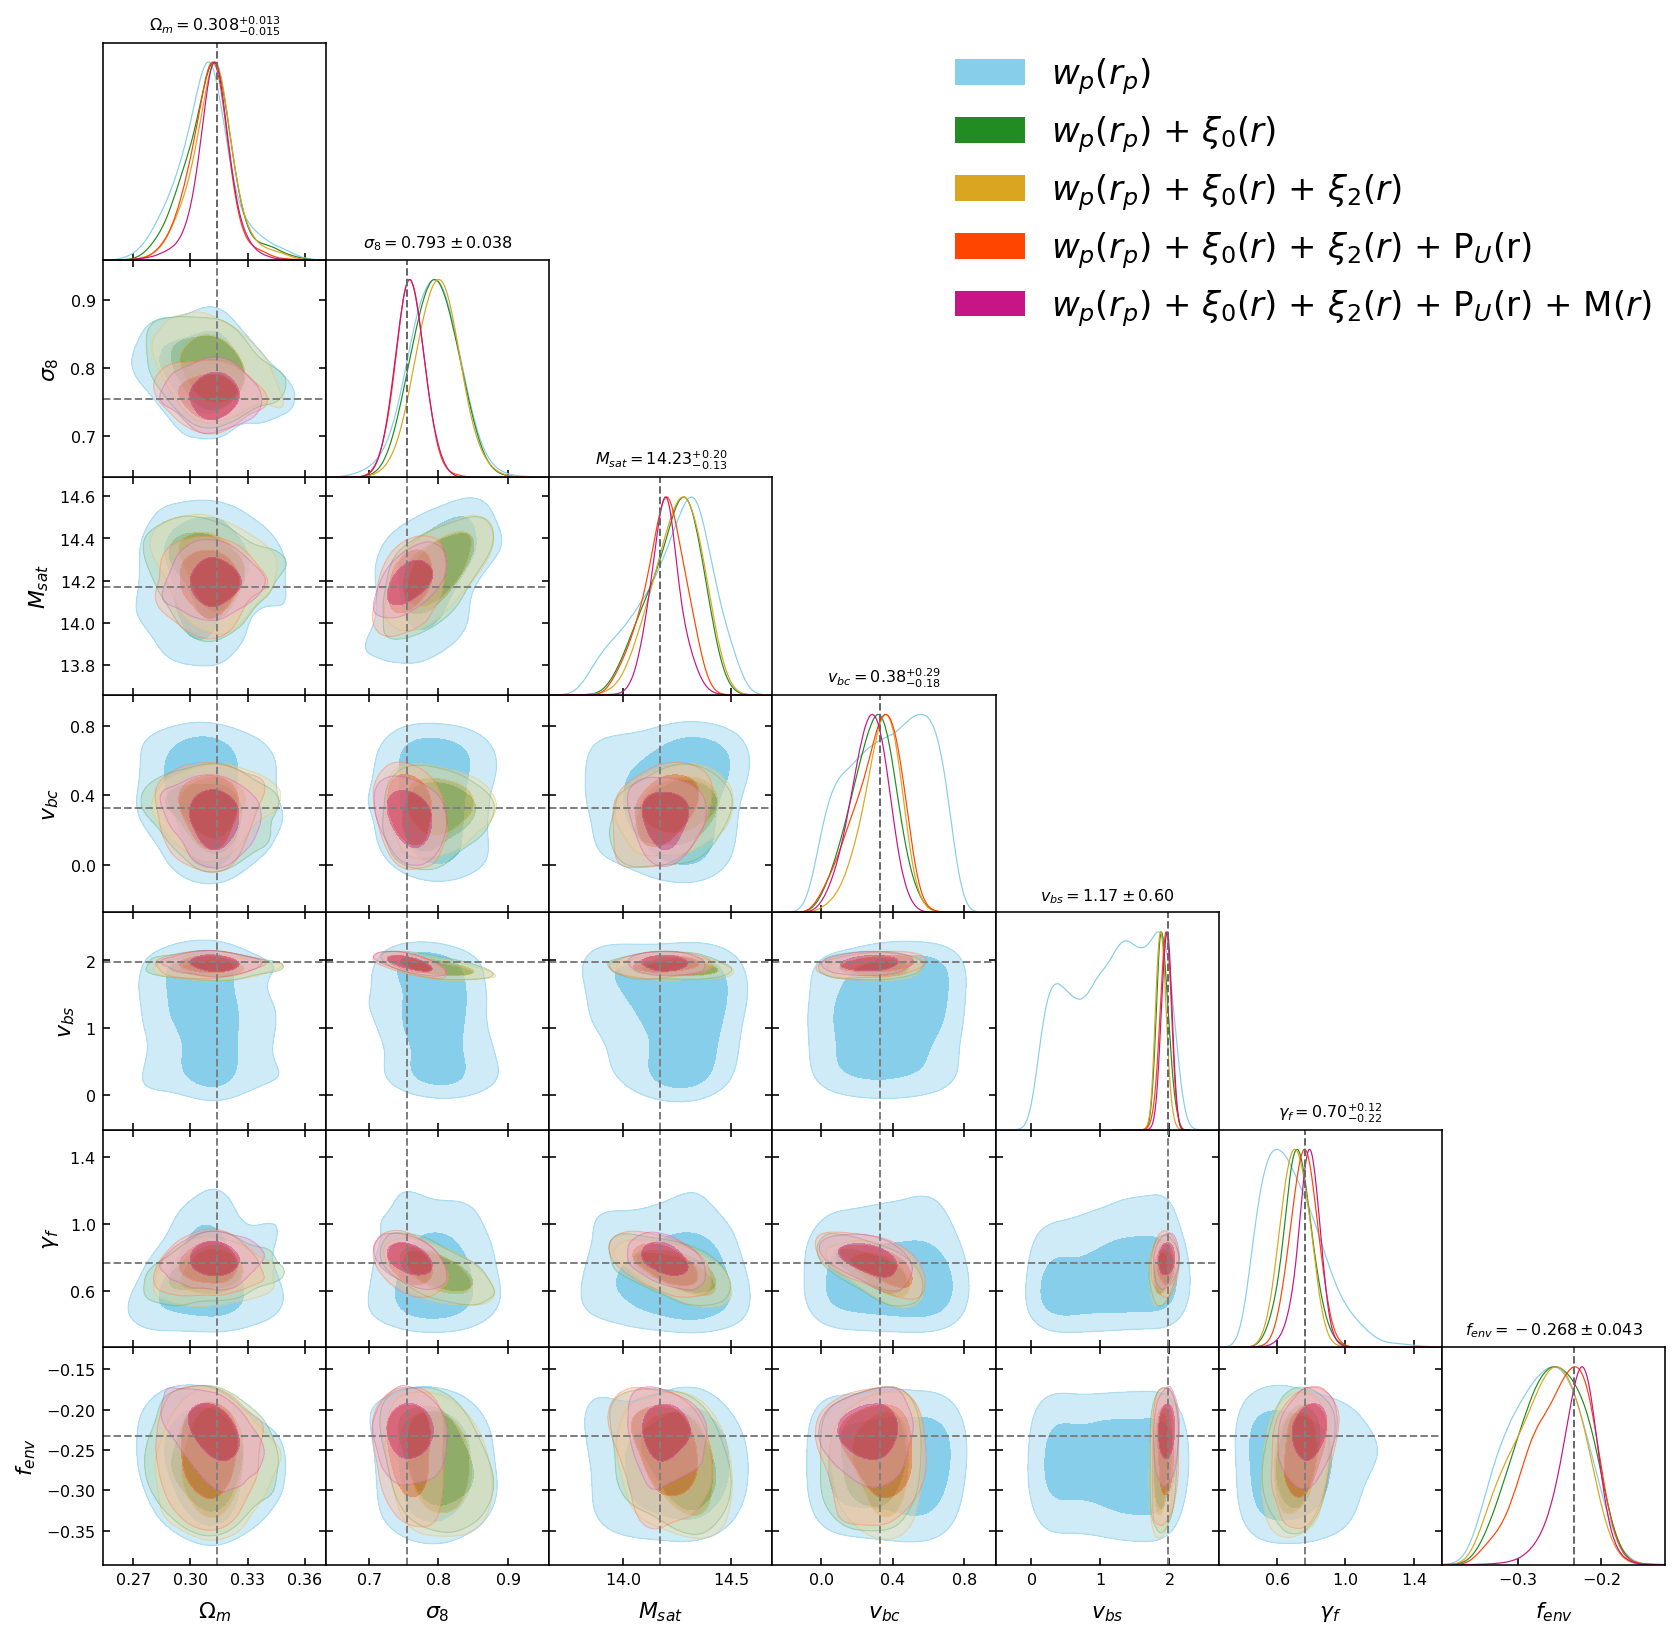

In [2]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']),
                ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=key_param_names)

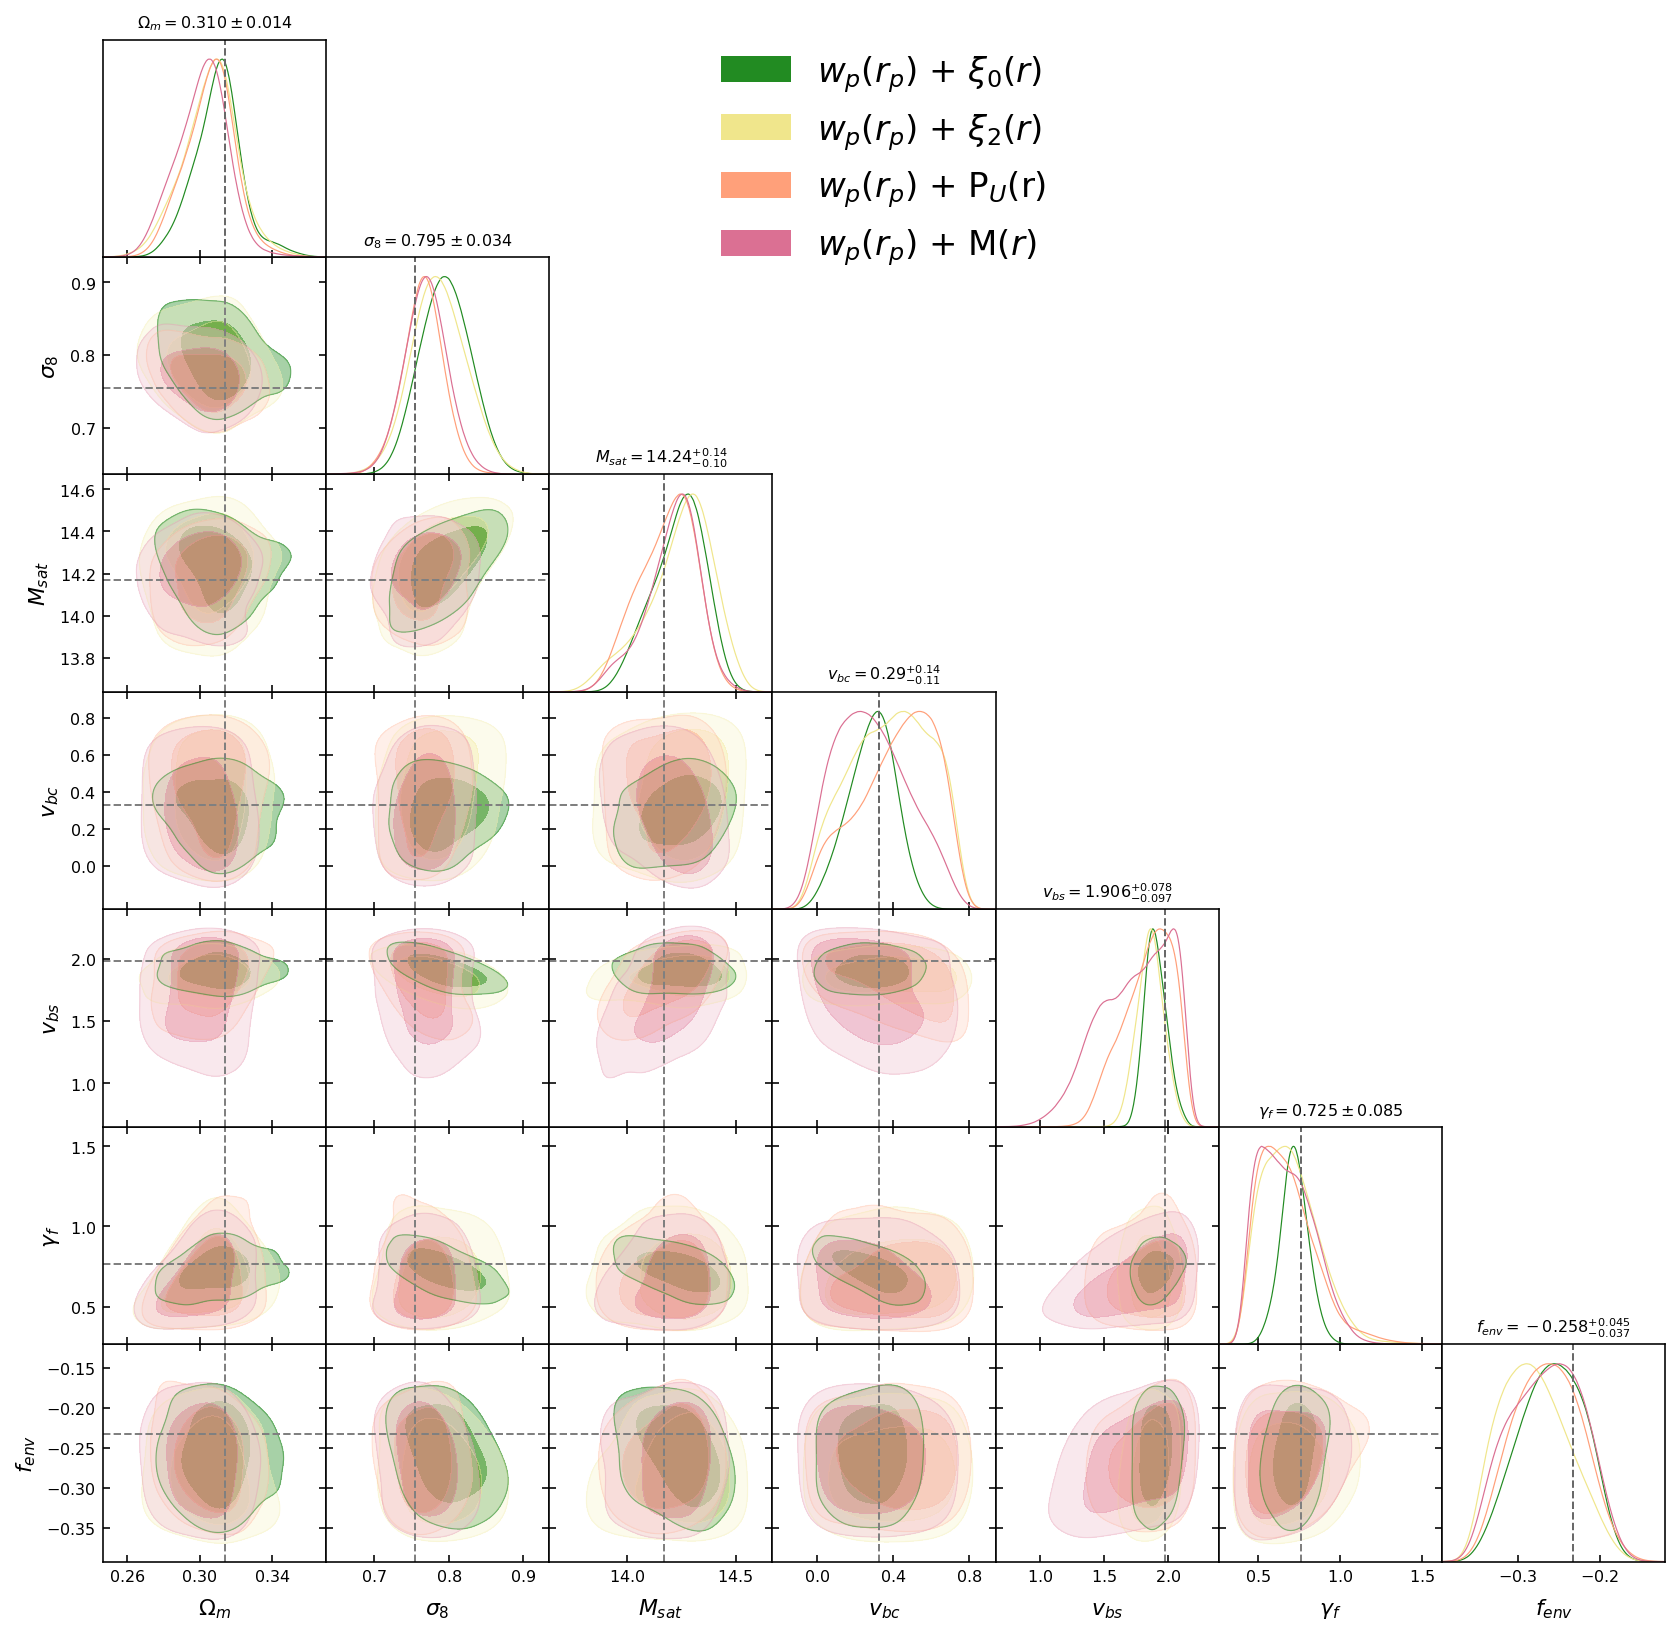

In [40]:
chaintags = [
             'wp_xi_c1h12_all',
             'wp_xi2_c1h12_all',
             'wp_upf_c1h12_all',
             'wp_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi2']),
                 make_label(['wp', 'upf']),
                 make_label(['wp', 'mcf']),
                ]
colors = [
          'forestgreen',
          'khaki',
          'lightsalmon',
          'palevioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper center',
                          params_toplot=key_param_names)

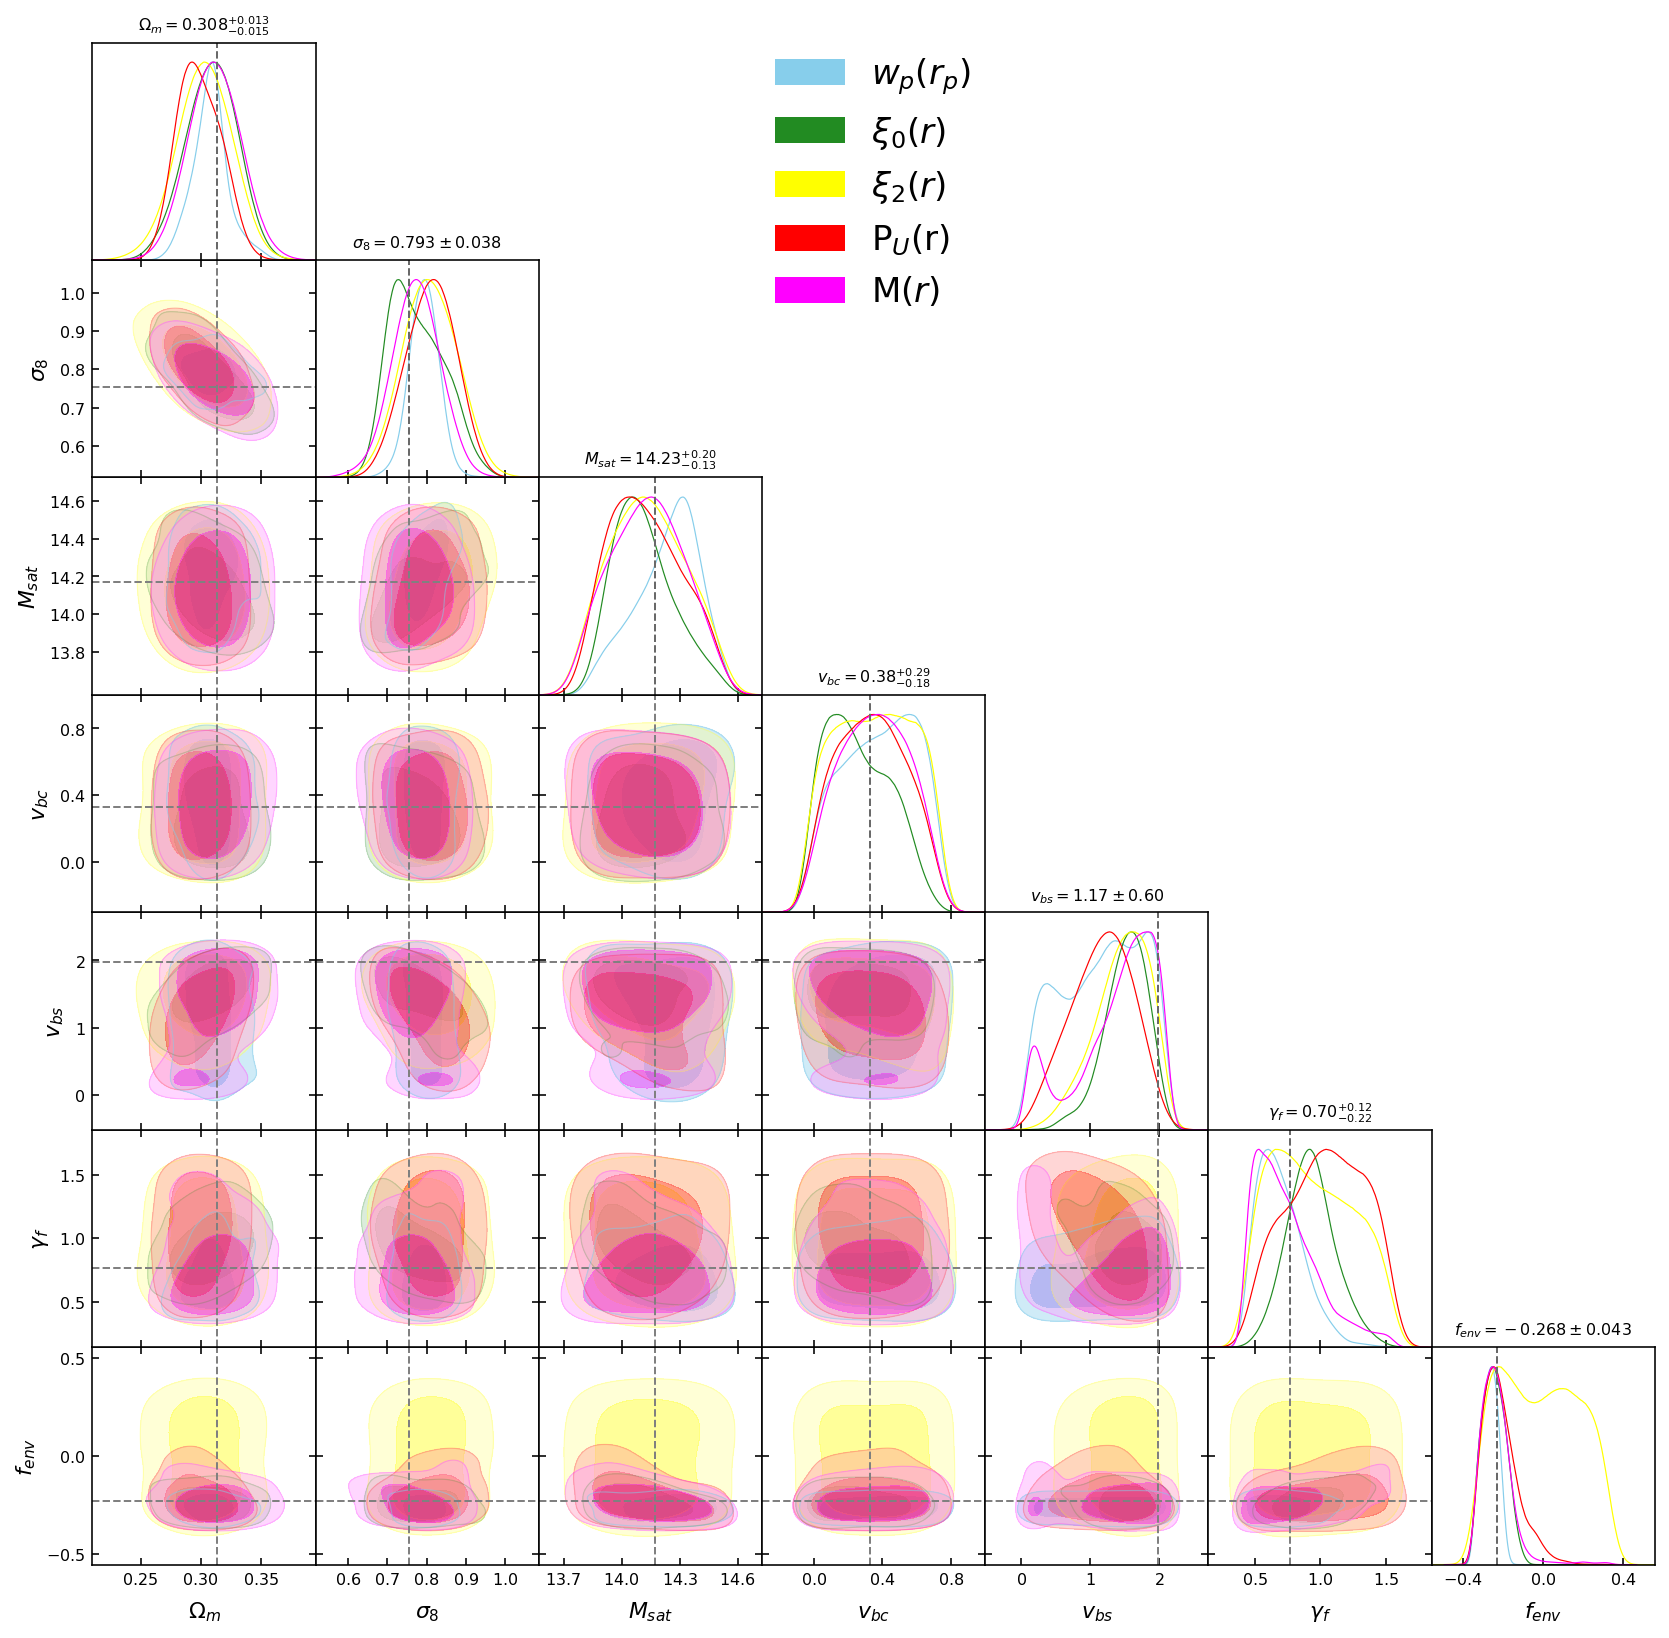

In [41]:
chaintags = ['wp_c1h12_all',
             'xi_c1h12_all',
             'xi2_c1h12_all',
             'upf_c1h12_all',
             'mcf_c1h12_all',
            ]
legend_labels = [
                 make_label('wp'),
                 make_label('xi'),
                 make_label('xi2'),
                 make_label('upf'),
                 make_label('mcf'),
                ]
colors = ['skyblue',
          'forestgreen',
          'yellow',
          'red',
          'magenta'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper center',
                          params_toplot=key_param_names)

## Statistical results

In [5]:
def get_medians(samples_equal):
    medians = np.median(samples_equal, axis=0)
    return medians

# now for testing
def get_means(samples_equal):
    # checked that same as dyfunc.mean_and_cov(samples, weights)
    # and np.std(x, axis=0) = np.sqrt(np.diag(cov))
    means = np.mean(samples_equal, axis=0)
    return means

def get_posterior_maxes(samples_equal, param_names):
    samps = MCSamples(names=param_names)
    samps.setSamples(samples_equal)
    maxes = []
    for i, pn in enumerate(param_names):
        xvals = np.linspace(min(samples_equal[:,i]), max(samples_equal[:,i]), 1000)
        dens = samps.get1DDensity(pn)   
        probs = dens(xvals)
        posterior_max = xvals[np.argmax(probs)]
        maxes.append(posterior_max)
    return maxes

def get_uncertainties(samples_equal):
    lowers = np.percentile(samples_equal, 16, axis=0)
    uppers = np.percentile(samples_equal, 84, axis=0)
    uncertainties = (uppers-lowers)/2.0
    return uncertainties

In [6]:
def bootstrap(data, function, n_resamples=1000):
    result_arr = np.empty(n_resamples)
    for i in range(n_resamples):
        sample = np.random.choice(data, size=n_resamples)
        result_arr[i] = function(sample)
    return result_arr

In [24]:
def plot_uncertainty_bar_chart(stat_strs_toplot, params_toplot, id_pairs, rotation=0):
    xvals = range(len(stat_strs_toplot))
    for j, pn in enumerate(params_toplot):    

        plt.figure(figsize=(5,5))

        uncertainties = np.empty(len(stat_strs_toplot))
        uncertainties_id_pairs = []
        yerrs_lo = np.empty(len(stat_strs_toplot))
        yerrs_hi = np.empty(len(stat_strs_toplot))
        for s, stat_str in enumerate(stat_strs_toplot):
            uncertainties_id_pairs = []
            for i, id_pair in enumerate(id_pairs):
                uncertainties_id_pairs.append(results_dict[stat_str][tuple(id_pair)][pn]['uncertainty'])
            uncertainties[s] = np.mean(uncertainties_id_pairs)
            means_resampled = bootstrap(np.array(uncertainties_id_pairs), np.mean, n_resamples=100)
            inverse_means_resampled = 1/means_resampled
            yerrs_lo[s] = np.percentile(inverse_means_resampled, 16)
            yerrs_hi[s] = np.percentile(inverse_means_resampled, 84)

        # prior
        uncertainty_prior = prior_dict[pn]['uncertainty']
        plt.axhline(1/uncertainty_prior, ls='--', color='grey')
        plt.text(0.3, 1.05*1/uncertainty_prior, 'prior', color='grey', fontsize=12)

        xticks = list(range(len(stat_strs_toplot)))    
        plt.bar(xvals, 1/uncertainties, yerr=[1/uncertainties-yerrs_lo, yerrs_hi-1/uncertainties], color=colors, width=0.2)#, tick_label=stat_strs)
        plt.xticks(xvals, labels, rotation=rotation)

        plt.title(fr'${param_labels[pn]}$')
        plt.ylabel(fr"1/$\sigma$")

In [8]:
def construct_results_dict(chaintag):
    
    chain_fn = f'../chains/param_files/chain_params_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')
    param_names = fw.attrs['param_names_vary']
    truths = fw.attrs['true_values']
    fw.close()
    
    chain_results_fn = f'../chains/results/results_{chaintag}.pkl'
    with open(chain_results_fn, 'rb') as pf:
        res = pickle.load(pf)
        samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        samples_equal = dyfunc.resample_equal(samples, weights)
        
    # add fsigma8
    idx_Omega_m = np.where(param_names=='Omega_m')[0][0]
    idx_gamma_f = np.where(param_names=='f')[0][0]
    idx_sigma_8 = np.where(param_names=='sigma_8')[0][0]
    f = samples_equal[:,idx_Omega_m]**0.55
    fsigma8 = f*samples_equal[:,idx_gamma_f]*samples_equal[:,idx_sigma_8]
    samples_equal = np.hstack((samples_equal, np.atleast_2d(fsigma8).T))
    param_names = np.append(param_names, 'fsigma8')
    fsigma8_true = truths[idx_Omega_m]**0.55 * truths[idx_gamma_f] * truths[idx_sigma_8]
    truths = np.append(truths, fsigma8_true)
        
    #print("gets")
    #print("means")
    means = get_means(samples_equal)
    #print("maxes")
    #maxes = get_posterior_maxes(samples_equal, param_names)
    #print("medians")
    medians = get_medians(samples_equal)
    #print("uncerts")
    uncertainties = get_uncertainties(samples_equal)
    #print("done gets")
    
    result_dict_single = {}
    for j, pn in enumerate(param_names):
        sub_dict = defaultdict(dict)
        sub_dict['mean'] = means[j]
        #sub_dict['max'] = maxes[j]
        sub_dict['median'] = medians[j]
        sub_dict['uncertainty'] = uncertainties[j]
        sub_dict['truth'] = truths[j]
        result_dict_single[pn] = sub_dict
        
    return result_dict_single

In [32]:
chaintag_prior = 'prior'
prior_dict = construct_results_dict(chaintag_prior)

# import utils
# import chain
# idxs_cosmo_vary = [i for i in range(len(cosmo_param_names)) if cosmo_param_names[i] in param_names]
# _hypercube_prior_cov_sqrt, _hypercube_prior_means = chain.get_cov_means_for_hypercube_prior(idxs_cosmo_vary)
# _hod_bounds = utils.get_hod_bounds()

# prior_dict = {}

# for j, cpn in enumerate(cosmo_param_names):
#     sub_dict = defaultdict(dict)
#     sub_dict['mean'] = _hypercube_prior_means[j]
#     sub_dict['uncertainty'] = _hypercube_prior_cov_sqrt[j,j]
#     prior_dict[cpn] = sub_dict

# for j, hpn in enumerate(hod_param_names):
#     sub_dict = defaultdict(dict)
#     sub_dict['mean'] = np.mean(_hod_bounds[hpn]) #TODO: check correct for log vals!! 
#     sub_dict['uncertainty'] = (_hod_bounds[hpn][1] - _hod_bounds[hpn][0])/np.sqrt(12) #via https://en.wikipedia.org/wiki/Continuous_uniform_distribution
#     prior_dict[hpn] = sub_dict
    
# # add fsigma8
# sub_dict = defaultdict(dict)
# sub_dict['mean'] = prior_dict['f']['mean'] * prior_dict['Omega_m']['mean']**0.55 * prior_dict['sigma_8']['mean'] #TODO: check correct!! 
# sub_dict['uncertainty'] = np.sqrt(prior_dict['f']['uncertainty']**2 + (prior_dict['Omega_m']['uncertainty']**0.55)**2 + prior_dict['sigma_8']['uncertainty']**2)
# prior_dict['fsigma8'] = sub_dict

In [9]:
results_dict = defaultdict(dict)
#results_dict = {}

id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

stat_strs = np.loadtxt('../tables/statistic_sets.txt', dtype=str)
#stat_strs = ['wp', 'wp_xi', 'wp_xi_upf', 'wp_xi_upf_mcf', 'wp_xi_upf_mcf_xi2']
#stat_strs = ['wp', 'wp_xi', 'wp_xi2', 'wp_upf', 'wp_mcf']
#stat_strs = ['wp', 'wp_xi2', 'wp_xi', 'wp_upf', 'wp_mcf', 'wp_xi_upf', 'wp_xi_upf_mcf', 'wp_xi_upf_mcf_xi2']
#stat_strs = ['wp']

for stat_str in stat_strs:
    print(stat_str)
    for i, id_pair in enumerate(id_pairs):
        
        id_cosmo, id_hod = id_pair
        chaintag = f'{stat_str}_c{id_cosmo}h{id_hod}_all'
        result_dict_single = construct_results_dict(chaintag)
        results_dict[stat_str][tuple(id_pair)] = result_dict_single

wp
xi
xi2
upf
mcf
wp_xi
wp_xi2
wp_upf
wp_mcf
wp_xi_xi2
wp_xi_xi2_upf
wp_xi_xi2_upf_mcf


### Adding in one observable at a time

In [25]:
stat_strs_toplot = ['wp', 'wp_xi', 'wp_xi_xi2', 'wp_xi_xi2_upf', 'wp_xi_xi2_upf_mcf']
#stat_strs_toplot = ['wp', 'wp_xi', 'wp_xi_upf']
labels = [
         make_label('wp'),
         '+'+make_label('xi'),
         '+'+make_label('xi2'),
         '+'+make_label('upf'),
         '+'+make_label('mcf'),
        ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']

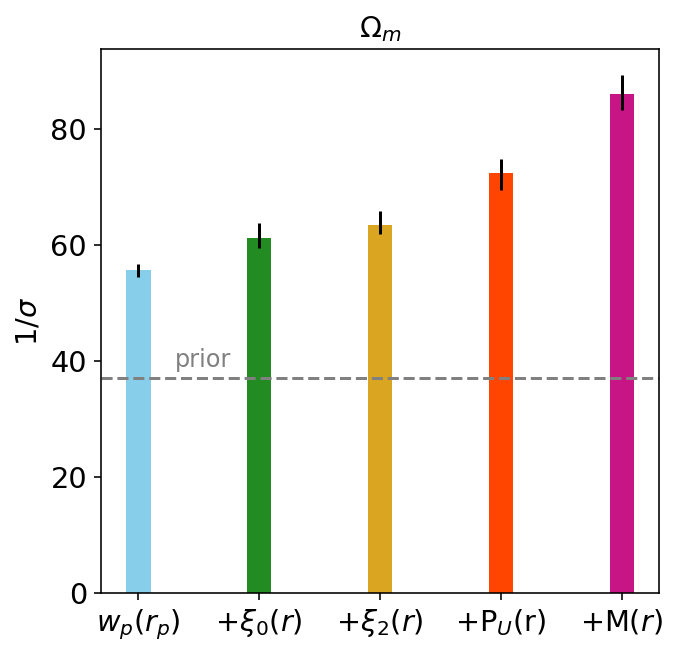

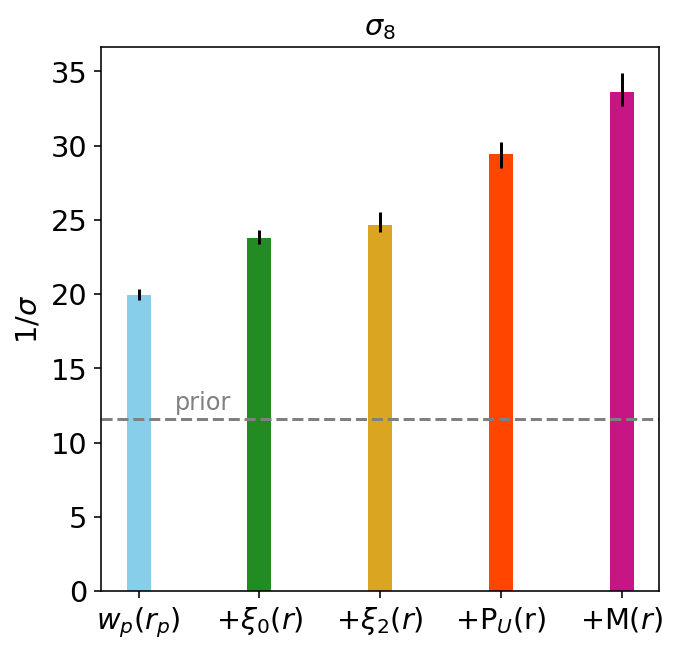

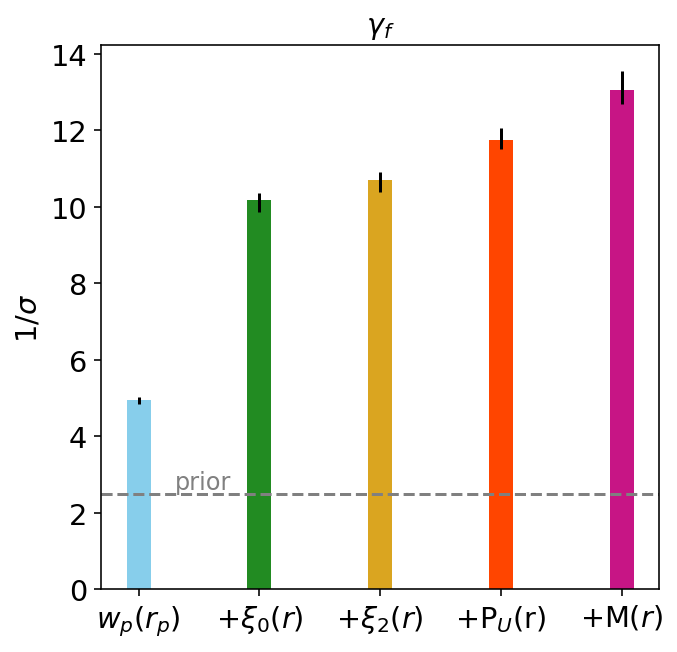

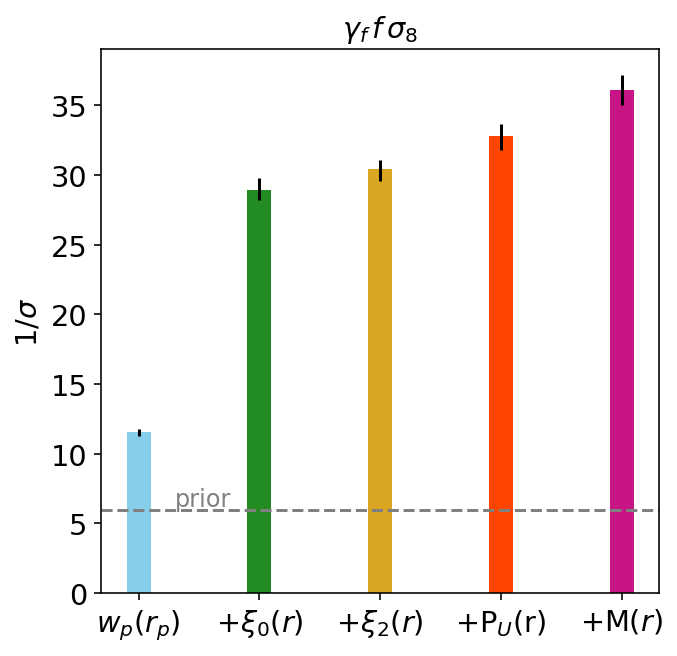

In [33]:
plot_uncertainty_bar_chart(stat_strs_toplot, params_toplot, id_pairs)

### Comparing wp + other observable

In [44]:
stat_strs_toplot = ['wp', 'wp_xi', 'wp_xi2', 'wp_upf', 'wp_mcf']
labels = [
         make_label('wp'),
         make_label(['wp', 'xi']),
         make_label(['wp', 'xi2']),
         make_label(['wp', 'upf']),
         make_label(['wp', 'mcf']),
        ]
colors = ['skyblue',
          'forestgreen',
          'khaki',
          'lightsalmon',
          'palevioletred'
         ]
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']

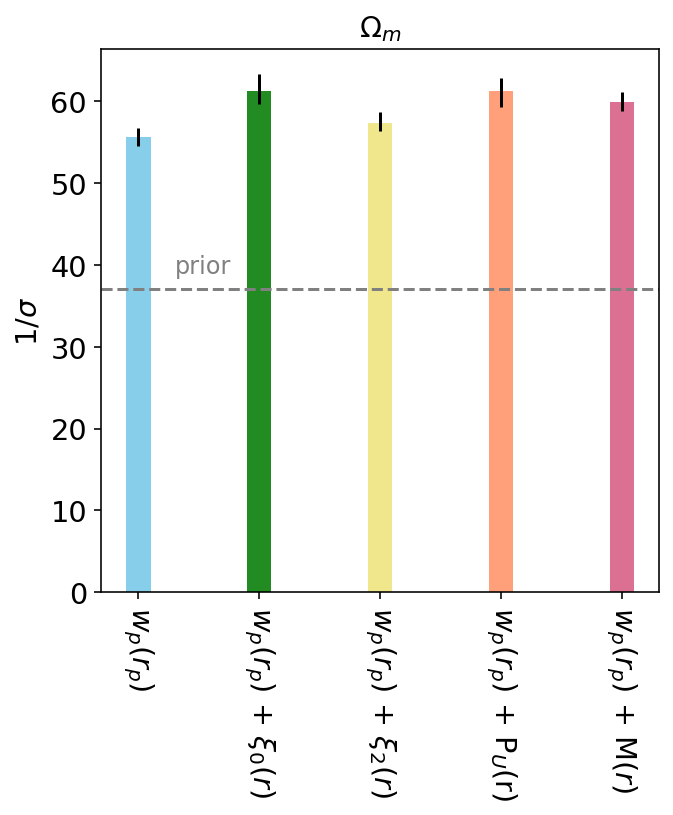

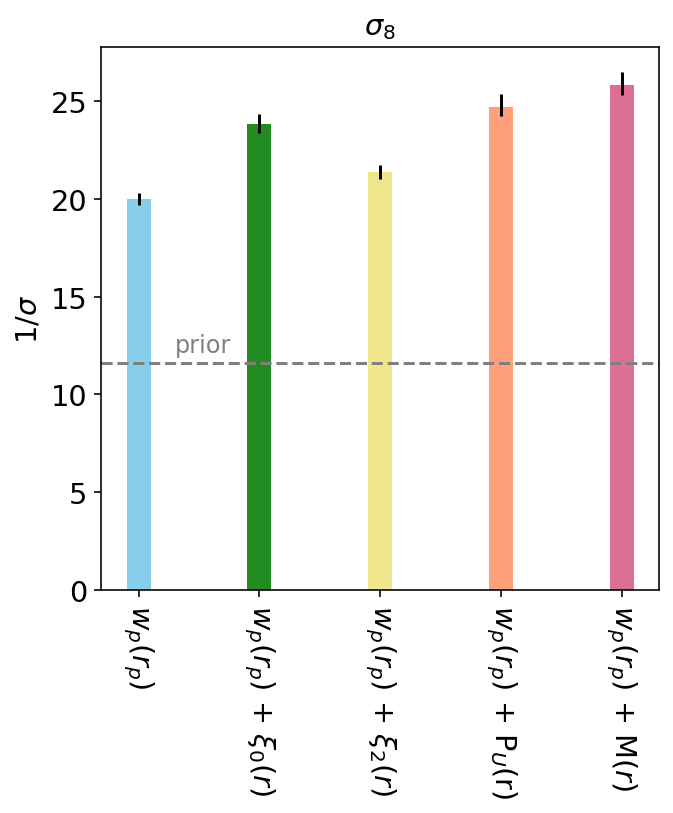

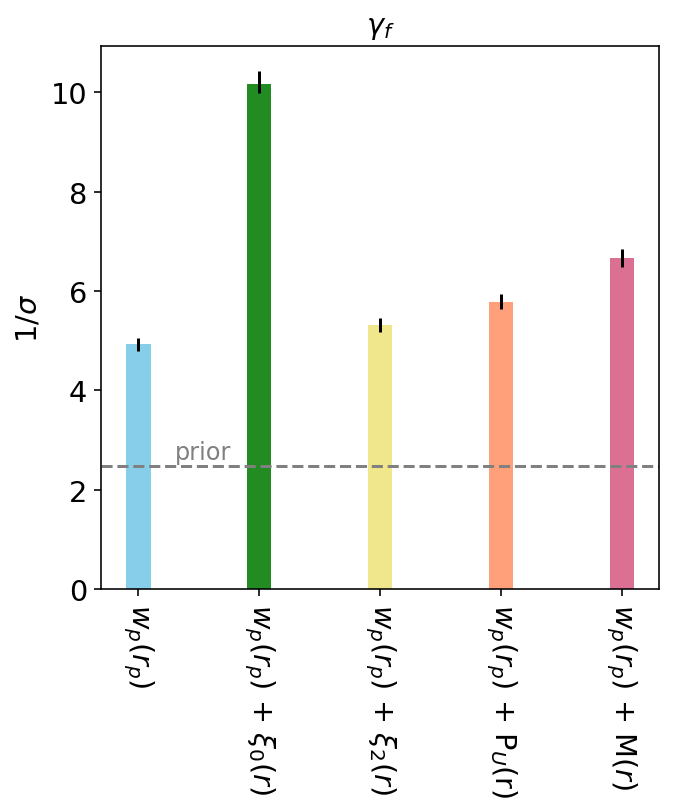

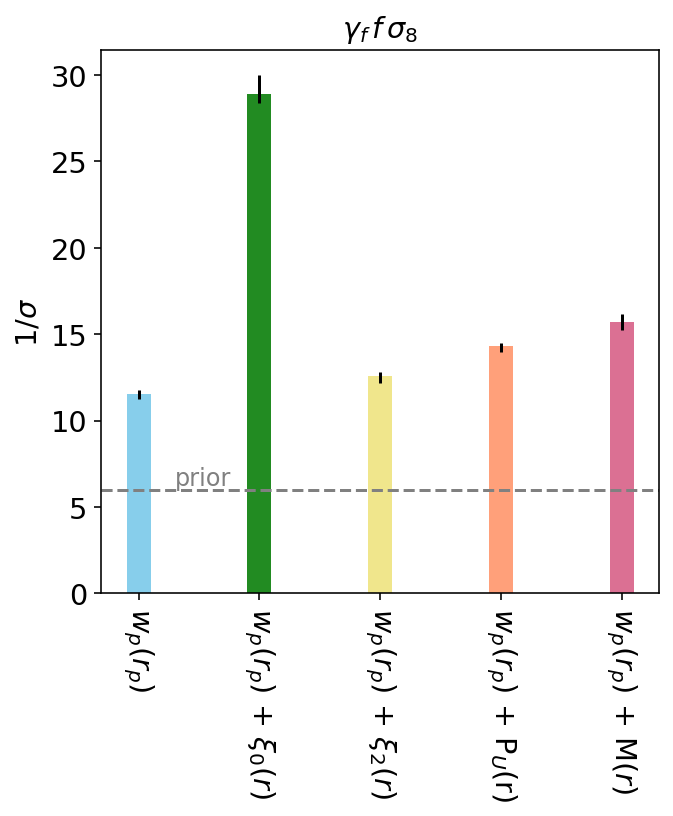

In [45]:
plot_uncertainty_bar_chart(stat_strs_toplot, params_toplot, id_pairs, rotation=270)

### Single observable

In [36]:
stat_strs_toplot = ['wp', 'xi', 'xi2', 'upf', 'mcf']
labels = [
         make_label('wp'),
         make_label('xi'),
         make_label('xi2'),
         make_label('upf'),
         make_label('mcf'),
        ]
colors = ['skyblue',
          'forestgreen',
          'yellow',
          'red',
          'magenta'
         ]
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']

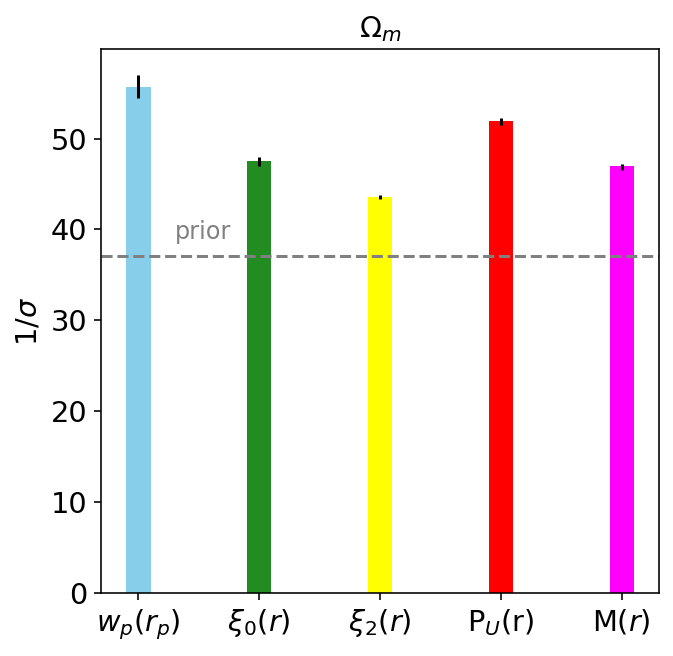

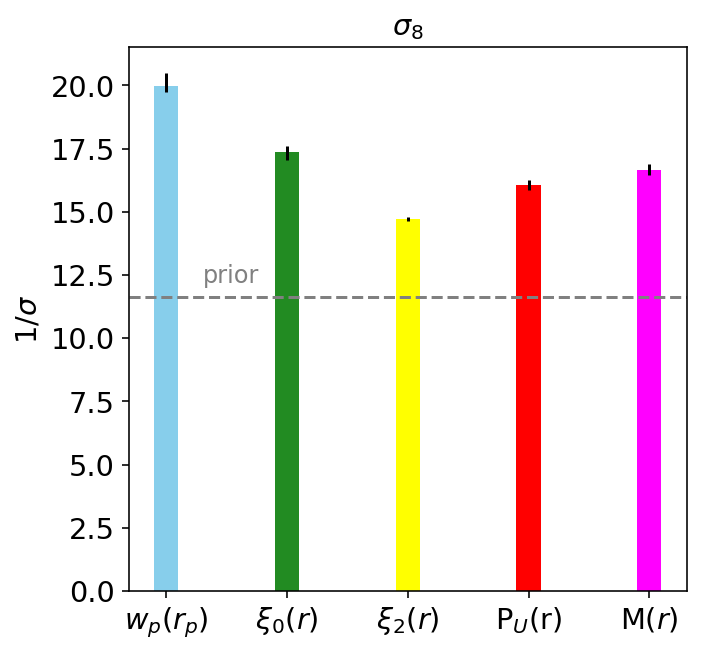

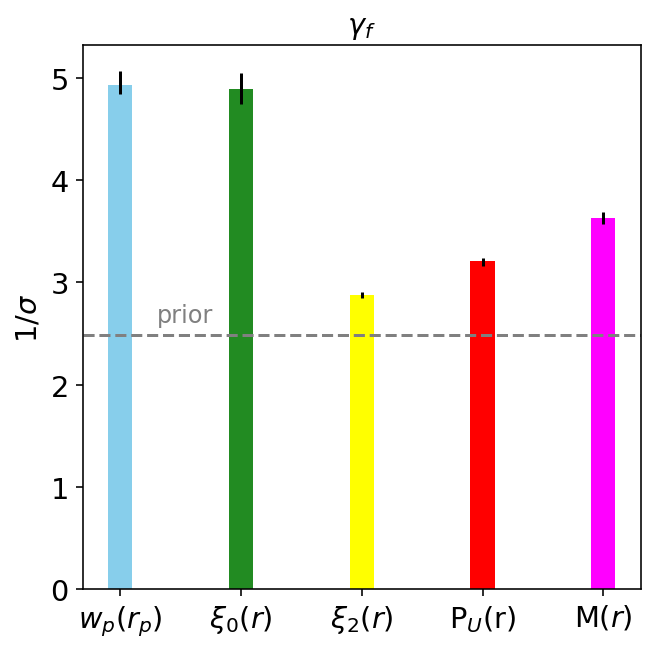

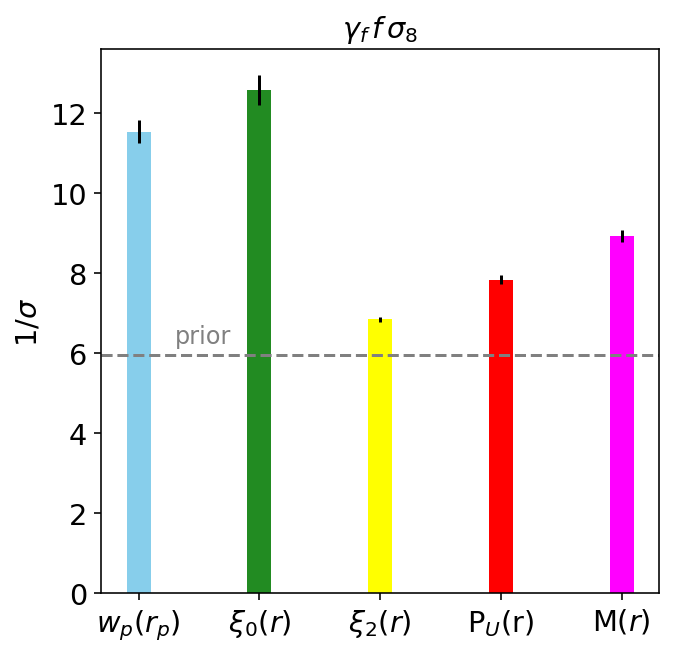

In [37]:
plot_uncertainty_bar_chart(stat_strs_toplot, params_toplot, id_pairs)